In [22]:
import statsmodels.api as sm

Read samples

In [8]:
indir = "{}/sex_chromosome_coverage".format(data_dir)
with open("{}/Samples".format(indir), "r") as sf:
    samples = [line.strip() for line in sf]

Read sexual chromosome strings

In [9]:
sp2chrom = {}
with open("../../data/Species_to_chromosomes.txt", "r") as fh:
    for line in fh:
        sp, chrX, chrY = line.split()
        sp2chrom[sp] = [chrX, chrY]

Read depths across genomic windows

In [10]:
depths = pd.DataFrame()
for s in samples:
    dp_df = pd.read_csv("{}/depth/{}.regions.bed.gz".format(indir, s), sep="\t", header=None)
    dp_df.columns = ["chrom","start","end","dp"]
    sp = s.split(".")[0]
    dp_df["chrom"] = ["A" if c not in sp2chrom[sp] else "X" if sp2chrom[sp][0]==c else "Y" for c in dp_df.chrom]
    dp_df["indiv"] = s
    depths = pd.concat([depths, dp_df], axis=0)
    
depths["l"] = depths.end - depths.start
depths = depths[depths.l>500e3].reset_index(drop=True)

Normalize data and get sex of individual

In [14]:
# Norm
autosome_mean = depths[depths.chrom=="A"].groupby("indiv")["dp"].mean().to_dict()
depths["norm_dp"] = [r.dp/autosome_mean[r.indiv] for i,r in depths.iterrows()]
depths_x = depths[(depths.chrom=="X")]

# Sex of individual
pd.options.mode.chained_assignment = None
config = pd.read_csv("{}/config_file.tsv".format(indir),sep="\t",header=None)
config.columns = ["indiv","lane","rep","fastq","sex"]
config["indiv_rep"] = ["{}.{}".format(i,l) for i,l in zip(config.indiv, config.lane)]
indiv2sex = config.set_index("indiv_rep")["sex"].to_dict()
depths_x["sex"] = [indiv2sex[r.indiv] for i,r in depths_x.iterrows()]

Merge with stats for 1Mb windows

In [18]:
thamn_stats = pd.read_csv("{}/Naja_naja.Z.seq_stats.txt.gz".format(indir),sep="\t",compression="gzip", header=None)
thamn_stats.columns = ["chrom","start","end","gcu","atu","totalu","gc","at","total","rmsk_frac","n"]
thamn = depths_x[depths_x.indiv=='Thamnophis_elegans.i1'].reset_index(drop=True)
thamn_merged = thamn.set_index("start").join(thamn_stats.set_index("start"),lsuffix="left").reset_index()

thamn_phylo = pd.read_csv("../../scripts/merged_features/Snakes.Thamnophis_elegans.features.txt.gz",sep="\t")
zphylo = thamn_phylo[thamn_phylo.chrom==sp2chrom["Thamnophis_elegans"][0]].reset_index(drop=True)
thamn_merged["excluded"] = [s<10e3 for s in zphylo["size"].values[:-1]]

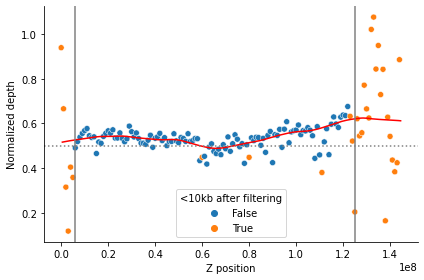

In [28]:
f,ax = plt.subplots()

subd = thamn_merged
x = np.array(subd.start + 500e3)
y = subd.norm_dp.values
frac = subd.rmsk_frac
lowess = sm.nonparametric.lowess(y,x, frac=0.2)

sns.scatterplot(data=subd, x="start",y="norm_dp",hue="excluded")
ax.plot([d[0] for d in lowess], [d[1] for d in lowess], color="red")
ax.axhline(y=0.5, linestyle="dotted",color="gray")
ax.axvline(x=6e6,color="gray")
ax.axvline(x=125e6,color="gray")
ax.legend(title="<10kb after filtering")
ax.set_xlabel("Z position")
ax.set_ylabel("Normalized depth")
sns.despine()
plt.tight_layout()
plt.savefig("../pdfs/Figure_SX_Thamnophis_sirtalis_PAR.pdf")